In [1]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from statistics import NormalDist
import pickle
import networkx as nx

### Thesis Plots

#### Website count

In [ ]:
df = pd.read_csv('input/thesis_WebsitesInfo.csv')

In [ ]:
fig = px.bar(data_frame=df, x='URL', y='Count', 
             text_auto='.2s', text='Percentage')

texts = [f'{round(value, 2)}%' for value in df['Percentage'].values]

#fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(texttemplate = texts, textposition = 'outside')
fig.update_layout(yaxis_range=[0, 60000])
fig.show()

In [ ]:
fig.write_html('output/WebsitesAnalysis.html',
                full_html=False,
                include_plotlyjs='cdn')

#### Description Test Results

In [ ]:
df = pd.read_csv('input/thesis_TestPrediction.csv')
df['bin'] = df.index.values / df.index.values[-1]

In [ ]:
def create_KDE(df, column, bw=None, num=501):
    x = np.linspace(0, 1, num=num)
    kernel = gaussian_kde(df[column], bw_method=bw) 
    y = kernel.pdf(x)
    
    return x, y

In [ ]:
x, y = create_KDE(df, 'Probability_1', num=101)

In [ ]:
correct_all = []
incorrect_all = []
for x1, x2 in zip(x, x[1:]):
    df_subset = df[(df['bin'].between(x1, x2))].groupby('Correct').count()
    try:
        total = df_subset.iloc[1, 0] + df_subset.iloc[0, 0]
        correct = df_subset.iloc[0, 0] / total
    except:
        correct = correct_all[-1]
    incorrect = 1 - correct
    
    correct_all.append(correct)
    incorrect_all.append(incorrect)

In [ ]:
correct_all.append(correct_all[-1])
incorrect_all.append(incorrect_all[-1])

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

x, y = create_KDE(df[df['Correct'] == 'Correct'], 'Probability_1', num=101)

fig.add_trace(go.Scatter(
    x=x, y=correct_all,
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='green'),
    stackgroup='one',
    groupnorm='percent'
))

x, y = create_KDE(df[df['Correct'] == 'Incorrect'], 'Probability_1', num=101)

fig.add_trace(go.Scatter(
    x=x, y=incorrect_all,
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='red'),
    stackgroup='one',
    showlegend=True,
))

fig.update_layout(
    showlegend=False,
    #xaxis_type='category',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

x, y = create_KDE(df, 'Probability_1')

fig.add_trace(
    go.Scatter(x=x, y=y, name="Description Density",
              line=dict(width=1.5, color='rgb(131, 90, 241)'),
               showlegend=True,
              ),
    secondary_y=True,
)

fig.layout.yaxis2.update(showticklabels=False, showgrid= False)

# Set x-axis title
fig.update_xaxes(title_text="Prediction Values")

# Set y-axes titles
fig.update_yaxes(title_text="Correct/Incorrect", secondary_y=False)
fig.update_yaxes(title_text="Data Distribution", secondary_y=True)

In [ ]:
fig.write_html('output/Classifier_testAccuracy.html',
                full_html=False,
                include_plotlyjs='cdn')

### Nx Graph

In [65]:
kg = [
    ('Brown bear', 'has part', 'claw'),
    ('Brown bear', 'has part', 'fur'),
    ('fur', 'has color', 'brown'),
    ('fur', 'has property', 'thick'),
    ('claw', 'part part', 'nail'),
    ('claw', 'has property', 'large'),
    ('nail', 'has property', 'sharp'),
    ('nail', 'has measurement', '5'),
    ('Brown bear', 'has part', 'nose'),
    ('nose', 'has property', 'large'),
]


df = pd.DataFrame(kg, columns=['source', 'edge', 'target'])

G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

#plt.figure(figsize=(8, 3))
labels = dict(zip(list(zip(df.source, df.target)),
                  df['edge'].tolist()))


node_size = {
    'Brown bear':5,
    'fur': 3,
    'nose': 3,
    'claw': 3,
    'nail': 3,
    'thick': 2,
    '5': 2,
    'sharp': 2,
    'brown': 2,
    'large': 2,
    'large': 2,
}

node_color = {
    'Brown bear': 'rgb(0, 153, 0, 2)',
    'fur':        'rgb(0, 204, 153)',
    'claw':       'rgb(0, 204, 153)',
    'sharp':      'rgb(255, 255, 255)',
    'brown':      'rgb(255, 255, 255)', 
    'thick':      'rgb(255, 255, 255)',
    'nail':       'rgb(0, 204, 153)',
    '5':          'rgb(255, 255, 255)',
    'large':      'rgb(255, 255, 255)',
    'large':      'rgb(255, 255, 255)',
    'nose':       'rgb(0, 204, 153)',
}
pos = nx.spring_layout(G)

node_labels = {node : node for node in G}

In [66]:
def graph_nodes(node_value):
    values = df[(df['source'] == node_value) | (df['target'] == node_value)][['source', 'target']].values
    return values[0][0], node_value

In [70]:
edge_x = []
edge_y = []
for (node0, _, node1) in kg:
    # Get all node names
    #node0, node1 = graph_nodes(node)
    
    #print(node, node0, node1)
    
    # Get coordinates
    x0, y0 = pos[node0]
    x1, y1 = pos[node1]
    # Append to list
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_sizes =  []
node_colors = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    size = node_size[node] * 10
    color = node_color[node]
    node_sizes.append(size)
    node_colors.append(color)
    
    
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        #colorscale='ylgnbu',
        color=node_colors,
        reversescale=True,
        size=node_sizes,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2,
                  color='black')
        )
)

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

#node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [71]:
node_sizes

[50, 30, 30, 20, 20, 30, 20, 20, 20, 30]

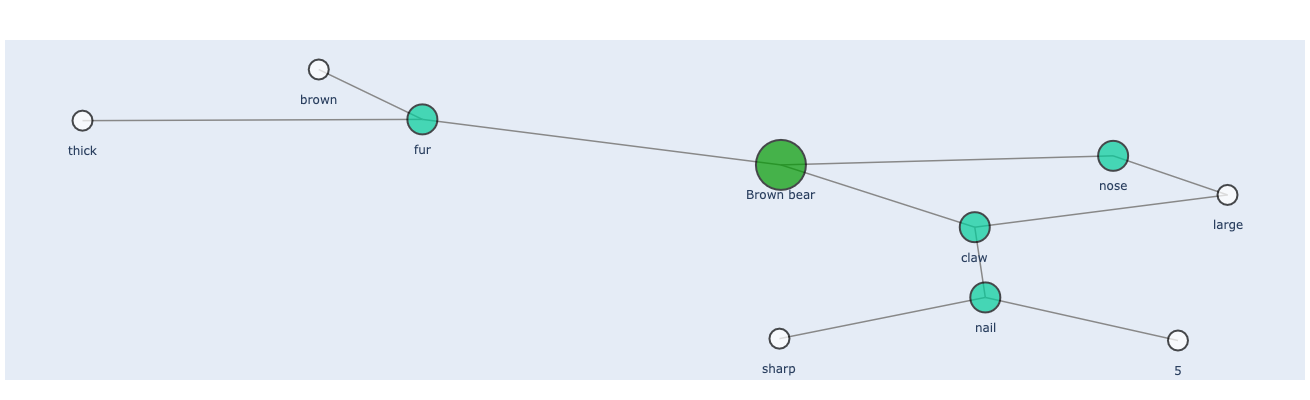

In [72]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)),
                )

# annotate your figure
for label, (x, y) in pos.items():
    fig.add_annotation(x=x,
                       y=y,
                       text = label,
                       showarrow = False,
                       yshift = -30)
                           
fig.update_layout(height=400, width=400)

fig.show()



### Paulien

In [ ]:
df = pd.read_excel('input/AllData_allyears.xlsx')

In [ ]:
df['date_str'] = df['Date'].apply(lambda x: str(x))
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
gardens = df['Sampling.area'].unique()
losses = ['TP_log', 'TN_log', 'PO4_log', 'NO3_log']

df_std = df.groupby([df.index, 'Sampling.area']).std()
df_mean = df.groupby([df.index, 'Sampling.area']).mean()
df_mean.reset_index(inplace=True)
df_std.reset_index(inplace=True)

fig = go.Figure().set_subplots(4, 1, vertical_spacing=0.05,
                              shared_xaxes=True,
                              shared_yaxes=True,
                              subplot_titles=gardens)

for idx, garden in enumerate(gardens):
    for loss in losses:
    mean_subset = df_mean[df_mean['Sampling.area'] == garden]
    std_subset = df_std[df_std['Sampling.area'] == garden]
    
    loss = [
    go.Scatter(
        name='TN log',
        x=mean_subset['Date'],
        y=mean_subset['TN_log'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
        showlegend=False
    ),
    go.Scatter(
        name='Upper Bound',
        x=std_subset['Date'],
        y=mean_subset['TN_log']+std_subset['TN_log'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False,
    ),
    go.Scatter(
        name='Lower Bound',
        x=std_subset['Date'],
        y=mean_subset['TN_log']-std_subset['TN_log'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
    ]
    
    fig.add_trace(loss[0], row=idx + 1, col=1)
    fig.add_trace(loss[1], row=idx + 1, col=1)
    fig.add_trace(loss[2], row=idx + 1, col=1)
    
fig.update_layout(
    hovermode="x",
    height=800,
)

#fig.for_each_yaxis(lambda y: y.update(title = ''))
fig.add_annotation(x=-0.02,y=0.5,
                   text="Loss (log)", textangle=-90,
                    xref="paper", yref="paper",
                  font=dict(size=20,))


fig.show()    
# fig.write_html(f'output/VoorPaulienTest.html',
#         full_html=False,
#         include_plotlyjs='cdn')

In [ ]:
mean_subset = df_mean[df_mean['Sampling.area'] == 'PAR']
std_subset = df_std[df_std['Sampling.area'] == 'PAR']

colors = [ '50,  92,  168', 
          '168, 135,   50', 
          '168,  58,   50', 
           '50, 168,  150',]
losses = ['TP_log', 'TN_log', 'PO4_log', 'NO3_log']


fig = go.Figure()

for loss, color in zip(losses, colors):
    conf = [
    go.Scatter(
        name=loss.split("_")[0],
        x=mean_subset['Date'],
        y=mean_subset[loss],
        mode='lines',
        line=dict(color=f'rgb({color})'),
        showlegend=True,
        legendgroup=loss,
    ),
    go.Scatter(
        name='Upper Bound',
        x=std_subset['Date'],
        y=mean_subset[loss]+std_subset[loss],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0.5),
        showlegend=False,
        hovertemplate=None,
        hoverinfo='skip', 
        legendgroup=loss,

    ),
    go.Scatter(
        name='Lower Bound',
        x=std_subset['Date'],
        y=mean_subset[loss]-std_subset[loss],
        marker=dict(color="#444"),
        line=dict(width=0.5),
        mode='lines',
        fillcolor=f'rgba({color}, 0.3)',
        fill='tonexty',
        showlegend=False,
        hoverinfo='skip', 
        legendgroup=loss,   
    )
    ]

    fig.add_trace(conf[0], )#row=idx + 1, col=1)
    fig.add_trace(conf[1], )#row=idx + 1, col=1)
    fig.add_trace(conf[2], )#row=idx + 1, col=1)
    
fig.update_layout(
    hovermode="x",
    #hovermode='x unified',
    #height=800,
    #title="Losses",
    xaxis_title="",
    yaxis_title="Losses (log)",
    legend_title="Loss Type",
    font=dict(
        #family="Courier New, monospace",
        size=10,
        color="black"
    )
)


#fig.update_traces(mode="markers+lines")
fig.show()